# Get sorted spikes and bouts and make rasters/gpfa

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts
- sort_raster_bout:
    - syncrhonization of nidaq/ap time events
    - spike sorting
    - labeling of sorted units for their corresponding nucleus
    - inspection of rasters
    
This notebook should not depend on the raw_data

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import threading
import json

import numpy as np
import pandas as pd

import scipy
from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2023-01-25 15:42:01,616 root         INFO     Running on pakhi.ucsd.edu


In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.pipeline import searchbout as sb

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util import h5util as h5u
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.dimension import gpfa

from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2023-01-25 15:42:03,304 root         INFO     all modules loaded


### Session parameters

In [3]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [4]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-04-29',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array




In [5]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2023-01-25 15:42:03,335 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx', 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29', 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/rig.json', 'kwd': '/scratch/

['0644_g0', '1055_g0', '1530_g0', '2234_stim_g0']

In [6]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

derived_folder = exp_struct['folders']['derived']

In [7]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/0644_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/0644_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/0644_g0',
  'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29/0644_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/0644_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0',
  'tmp': '/scratch/earneodo/tmp/0644_g0',
  'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29/0644_g0',
  'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/0644_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/0644_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-0

### load epoch files

In [8]:
### get the spikes df, clu df, bouts and syncrhonization files

## the sort
sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])

logger.info('Loading sort files from ' + sort_folder)

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df = pd.read_pickle(spk_df_path)


## the bout/stim
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict_ap0.pkl')
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_pd_ap0.pkl')

logger.info('loading synced bout and dict and pandas dataframe from {}, {}'.format(bout_dict_path, bout_df_path))
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
bout_df = pd.read_pickle(bout_df_path)


#load the mic, pressure if any
mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.wav')

s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'], sess_par['mic_chan'])
s_f_wav, pre_stream = wu.read_wav_chan(adc_path, sess_par['pre_chan'])

ap_sf = bout_dict['s_f_ap_0']

2023-01-25 15:42:03,858 root         INFO     Loading sort files from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0/sort_0
2023-01-25 15:42:07,989 root         INFO     loading synced bout and dict and pandas dataframe from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0/bout_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0/bout_pd_ap0.pkl


In [9]:
bout_dict_path

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/0644_g0/bout_dict_ap0.pkl'

In [10]:
# #load the mic, pressure if any
# mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.npy')
# adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.npy')

# mic_stream = np.memmap(adc_path)

In [11]:
bout_df.keys()

Index(['start_ms', 'end_ms', 'start_sample', 'end_sample', 'p_step', 'rms_p',
       'peak_p', 'bout_check', 'file', 'len_ms', 'syl_in', 'n_syl', 'peaks_p',
       'n_peaks', 'l_p_ratio', 'waveform', 'confusing', 'valid_waveform',
       'valid', 'spectrogram', 'start_ms_ap_0', 'start_sample_ap_0',
       'start_sample_naive'],
      dtype='object')

In [12]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0'])

#### Filter units by some FR statistics

In [13]:
def clu_n_spike(spk_df, cluster_id):
    spk_clu = spk_df[spk_df['cluster_id']==cluster_id]
    
    n_spike = spk_clu.index.size
    return n_spike

def fill_clu_meta(clu_df, spk_df):
    # mean FR
    clu_df['n_spike'] = clu_df['cluster_id'].apply(lambda x: clu_n_spike(spk_df, x))

fill_clu_meta(clu_df, spk_df)

In [14]:
t_rec = mic_stream.shape[0]/bout_dict['s_f']
total_ap_samp = t_rec * bout_dict['s_f_ap_0']

#total_ap_samp
spk_fr_cutoff = 0.0001 #spikes/sec
n_spk_cutoff = total_ap_samp * spk_fr_cutoff
n_spk_cutoff

45281.59460236221

####### just drop the units without spikes

In [15]:
clu_df = clu_df[clu_df['n_spike']>n_spk_cutoff]
clu_df.reset_index(inplace=True, drop=True)

### Visualize a bout together with the neural traces

In [16]:
plt.rcParams['lines.linewidth'] = 0.1

In [17]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

### collect all the bouts

In [18]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0'])

In [19]:
def collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, t_pre=-2, t_post=2):
    # get t_pre, t_post in samples for wav, ap
    # tet start_end samples for each
    # collect the spikes
    # collect the streams
    bout_dict['t_pre'] = t_pre
    bout_dict['t_post'] = t_post
    
    sf_ap = bout_dict['s_f_ap_0']
    sf = bout_dict['s_f']
    
    pre_ap, post_ap = [int(x * sf_ap) for x in [t_pre, t_post]]
    pre_wav, post_wav = [int(x * sf) for x in [t_pre, t_post]]
    
    bout_df['len_sample_ap_0'] = (bout_df['len_ms'] * sf_ap * 0.001).astype(int)
    bout_df['end_sample_ap_0'] = bout_df['start_sample_ap_0'] + bout_df['len_sample_ap_0']

    bout_df['spk_arr'] = bout_df.apply(lambda x: ks.get_window_spikes(spk_df, clu_list, 
                                                                      x['start_sample_ap_0'] + pre_ap, 
                                                                      x['end_sample_ap_0'] + post_ap), 
                                       axis=1)

    bout_df['mic_arr'] = bout_df.apply(lambda x: mic_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    bout_df['pre_arr'] = bout_df.apply(lambda x: pre_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    
    # while we are at it, compute the spectrograms (ms scale)
    bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), sf))
    
    # split the spectrogram to be able to work with hdf5 save/load.
    # don't want to be saving tuples, rather arrays
    bout_df[['f_xx', 't_xx', 's_xx']] = pd.DataFrame(bout_df['sxx'].tolist(), index=bout_df.index)
    
    bout_df['clu_id_arr'] = [clu_list for x in bout_df.index]
    bout_df.reset_index(inplace=True, drop=True)
    
    return bout_df

In [20]:
### one spk_arr
# mot_idx = 0

# start_ap = bout_df.loc[mot_idx, 'start_sample_ap_0']
# end_ap = bout_df.loc[mot_idx, 'end_sample_ap_0']

# spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap - 60000 , end_ap+60000)

In [21]:
clu_list = np.unique(clu_df.loc[(clu_df['group']=='good') & (clu_df['nucleus'].isin(['ra']) & (clu_df['n_spike']>n_spk_cutoff)), 
                                'cluster_id'])

t_pre = -0.5
t_post = 0.5

bout_df = collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, 
                           t_pre=t_pre, t_post=t_post)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:112: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [22]:
ms_sample_ap = int(1*0.001*bout_dict['s_f_ap_0'])
bout_df['spk_ms_arr'] = bout_df['spk_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, ms_sample_ap)))

In [23]:
bout_df.index.size

90

##### sanity check, plot one of the bout-rasters

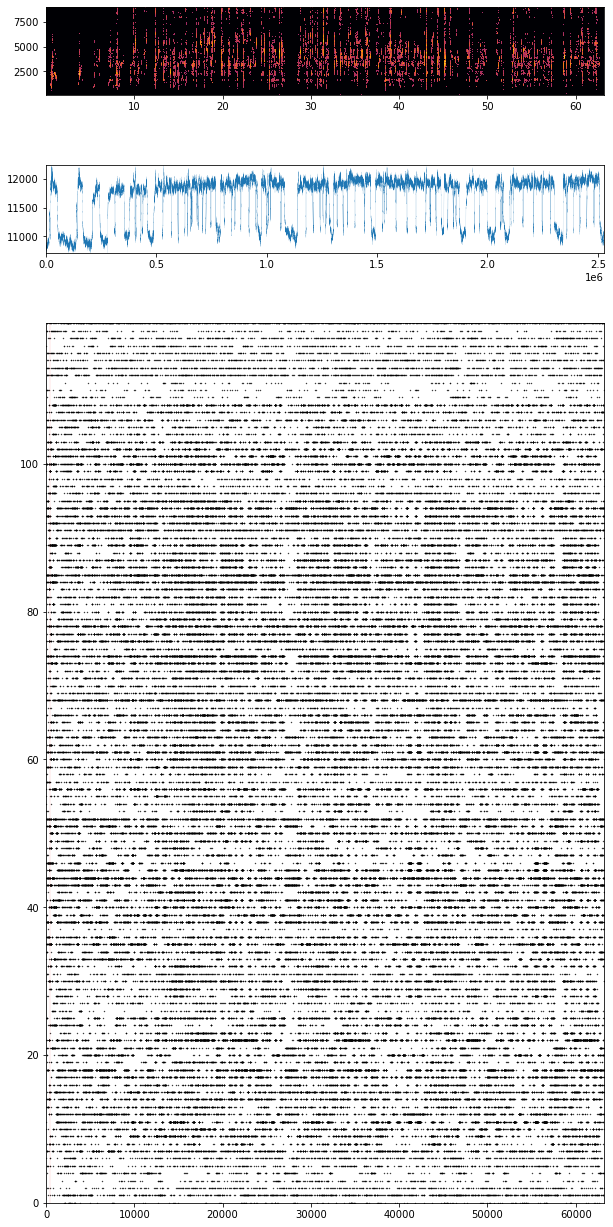

In [24]:
def plot_bout(bout_series, bout_dict):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_arr']
    spk_arr = bout_series['spk_ms_arr']
    # plot
    
    fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    pu.plot_as_raster(spk_arr, t_0=int(-t_pre*1000), ax=ax[2])
    
plot_bout(bout_df.iloc[0], bout_dict)

### get all the gpfa

#### Make two separate gpfa fits, one for the vocal part of the bout and one for the 'preparatory' part

In [25]:
# #complete bouts
# bout_df['spk_train'] = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0']))
# all_spk_train_list = list(bout_df['spk_train'])

# #
# bout_spk_train_list = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0'],
#                                                                                    t_pre=t_pre, 
#                                                                                     t_post=t_post)
#                                               )

In [26]:
# prep_spk_train_list = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0'],
#                                                                                    t_pre=0, 
#                                                                                     t_stop=-t_pre)
#                                               )

In [27]:
# specify fitting parameters
gpfa_bin_ms = 15
#bin_size = gpfa_bin_ms * pq.ms
latent_dimensionality = 8

bout_dict['gpfa_bin_ms'] = gpfa_bin_ms
bout_dict['gpfa_xdim'] = latent_dimensionality

#### fit the vocal part, project all to this fit

In [28]:
# gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

# #fit
# gpfa_2dim.fit(bout_spk_train_list)

# #project
# bout_fit_list = gpfa_2dim.transform(all_spk_train_list)

# # get to the dataframe
# bout_df['spk_gpf'] = bout_fit_list

#### fit preparatory part, project all to this fit

In [29]:
# gpfa_prep = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

# #fit
# gpfa_prep.fit(prep_spk_train_list)

# #project
# prep_fit_list = gpfa_prep.transform(all_spk_train_list)

# # get to the dataframe
# bout_df['spk_gpf-prep'] = prep_fit_list

### alternative gpfas

# make different fits with a single function on a thread
- one full
- one to the prepparatory activity
- on to just the bout
- one to the post-bout


In [30]:
spk_train_kwargs_dict = {}

#full
#spk_train_kwargs_dict['full'] = {'s_f': bout_dict['s_f_ap_0']}

#pre
#spk_train_kwargs_dict['pre'] = {'s_f': bout_dict['s_f_ap_0'], 't_pre': 0, 't_stop': -t_pre}

#bout
spk_train_kwargs_dict['bout'] = {'s_f': bout_dict['s_f_ap_0'], 't_pre': t_pre, 't_post': t_post}

#post
# fuck you
#spk_train_kwargs['bout'] = {'s_f': bout_dict['s_f_ap_0'], t_pre=t_pre, t_post=t_post}

In [31]:
###### if debugging, make a bout_df with just the first 2 bouts
# bout_df.reset_index(inplace=True, drop=True)
# bout_df.drop(index=bout_df.index[2:], inplace=True)

In [32]:
def fit_bout_gpfa(bout_df: pd.DataFrame, bout_dict: dict, spk_train_kwargs_dict, h5_name: str,
                 overwrite=False):
    # getting ready for making this a process that:
    # runs the gpfa models
    # gets spectrograms
    # saves to h5 file
    bout_df_path = os.path.join(exp_struct['folders']['processed'], h5_name)
    if os.path.isfile(bout_df_path):
        logger.warning('File already exists {}'.format(bout_df_path))
        if overwrite:
            logger.warning('Will overwrite it!')
        else:
            raise RuntimeError('Dont want to overwrite: will stop')
    
    # get spectrograms
    logger.info('Getting spectrograms')
    bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), bout_dict['s_f']))
    
    # get filtered pressure trace
    logger.info('Filtering pressure')
    b, a = scipy.signal.butter(4, 1000, 'lp', fs=bout_dict['s_f'], output='ba')
    bout_df['pre_filt'] = bout_df['pre_arr'].apply(lambda x: signal.filtfilt(b, a, x))
    
    # get pca
    pca = PCA(n_components=3, svd_solver='full')
    all_x = np.hstack(bout_df['sxx'].apply(lambda x: x[2]))
    all_x[all_x==np.nan] = 1 ### better do a zscore
    # fit all
    pca.fit(np.log(all_x.T))
    # project all
    bout_df['sxx_pc'] = bout_df['sxx'].apply(lambda x: pca.transform(np.log(x[2].T)))
    
    # Get gpfa
    gpfa_keys = []
    gpfa_model_dict = {}
    for k, spk_train_kwargs in spk_train_kwargs_dict.items():
        logger.info('Fitting for {}'.format(k))
        df_key = 'spk_gpf-{}'.format(k)
        gpfa_model_dict[k], bout_df[df_key] = gpfa.gpfa_for_bout(bout_df, bout_dict, 
                                                                 bin_size_ms=bout_dict['gpfa_bin_ms'], 
                                                                 x_dim=bout_dict['gpfa_xdim'], 
                                                                 spk_train_kwargs=spk_train_kwargs)
        gpfa_keys.append(df_key)
    
    attr_keys = ['start_ms', 'end_ms', 'len_ms', 
             'start_sample', 'end_sample',
             'start_ms_ap_0', 'start_sample_ap_0',
             'start_sample_naive', 'len_sample_ap_0', 'end_sample_ap_0',
             'bout_check', 'confusing', 'file']

    dset_keys = ['mic_arr', 'pre_arr', 'pre_filt', 'syl_in',
                 'f_xx', 't_xx', 's_xx', 'sxx_pc',
                 'spk_arr']
    
    extra_dset_keys = []
    dset_keys = dset_keys + gpfa_keys + extra_dset_keys
    logger.info('will save dset keys: {}'.format(dset_keys))
    
    # extra dset_keys that will not necessarily always be there
    #extra_dset_keys = ['spk_gpf-full', 'spk_gpf-hyb']
    dict_keys = ['s_f', 's_f_nidq', 's_f_ap_0', 't_pre', 't_post', 'gpfa_bin_ms', 'gpfa_xdim']

    fu.makedirs(exp_struct['folders']['processed'])
    logger.info('Saving the gpfa, pca results onto an hdf5 file {}'.format(bout_df_path))
    h5u.bouts_to_h5(bout_df, bout_dict, bout_df_path, 
                    dset_keys, 
                    attr_keys, 
                    dict_keys)
    logger.info('done')
    
bout_gpfa_h5_fname = 'bout_df_gpfa-15ms.h5'
gpfa_process = threading.Thread(target=fit_bout_gpfa, 
                       args=(bout_df, bout_dict, spk_train_kwargs_dict, bout_gpfa_h5_fname))
gpfa_process.start()

#fit_bout_gpfa(bout_df, bout_dict, spk_train_kwargs_dict, 'bout_df_gpfa-15-testt.h5')

#### If running whole notebook, insert a chekcpoint here to wait on the process

In [33]:
raise KeyboardInterrupt

2023-01-25 15:44:32,442 root         INFO     Getting spectrograms


KeyboardInterrupt: 

In [35]:
# to check whether the process is still running (ture) or if it ended (false)
gpfa_process.is_alive()

False

### load the bouts with gpfa

In [36]:
bout_h5_path = os.path.join(exp_struct['folders']['processed'], bout_gpfa_h5_fname)
#bout_df, bout_dict = h5u.bouts_from_h5(bout_h5_path, exclude_dset=['spk_arr'])
# load with everything and spikes to get the pca of the neural traces
bout_df, bout_dict = h5u.bouts_from_h5(bout_h5_path, exclude_dset=['spk_arr'])
bout_df.sort_values(['len_ms'], ascending=False, inplace=True, ignore_index=False)

In [37]:
bout_df.keys()

Index(['f_xx', 'mic_arr', 'pre_arr', 'pre_filt', 's_xx', 'spk_gpf-bout',
       'sxx_pc', 'syl_in', 't_xx', 'bout_check', 'confusing', 'end_ms',
       'end_sample', 'end_sample_ap_0', 'file', 'len_ms', 'len_sample_ap_0',
       'start_ms', 'start_ms_ap_0', 'start_sample', 'start_sample_ap_0',
       'start_sample_naive', 'bout_idx'],
      dtype='object')

In [38]:
%matplotlib inline

array([<AxesSubplot:>, <AxesSubplot:ylabel='sound amplitude (arb)'>,
       <AxesSubplot:title={'center':'RA GPFA full bout'}>, <AxesSubplot:>,
       <AxesSubplot:title={'center':'pressure'}>], dtype=object)

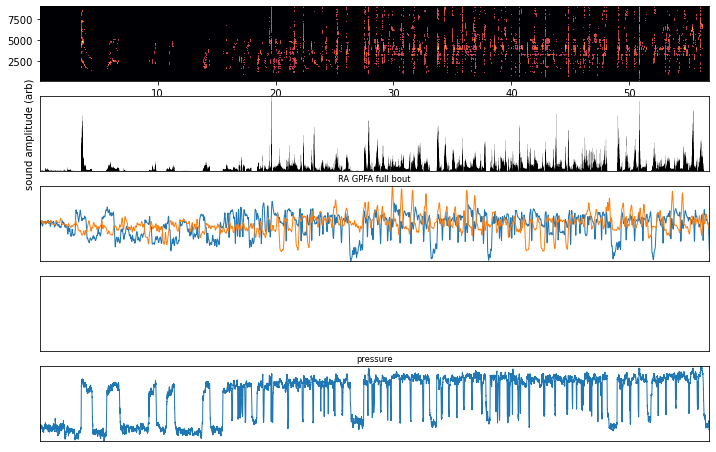

In [39]:
### se them together all for a bout now
def plot_bout_projections(bout_series, gpf_key: str='spk_gpf'):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series[gpf_key]
    #gpf_prep = bout_df['spk_gpf-prep']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    sxx = bout_series['s_xx']
    t = bout_series['t_xx']
    f = bout_series['f_xx']
    
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    
    ax[1].plot((np.abs(mic_arr)), 'k');
    ax[1].set_ylabel('sound amplitude (arb)')

    ax[2].set_title('RA GPFA full bout')
    #ax[2].plot(sxx_pc, lw=1);
    ax[2].plot(gpf[:2].T, lw=1);


    ax[4].set_title('pressure');
    ax[4].plot(pre_arr, lw=1);
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return ax


plot_bout_projections(bout_df.iloc[1], gpf_key='spk_gpf-bout')